# Boosting for Time-Series Prediction

In [4]:
import tigercontrol
import jax.numpy as np
from tigercontrol.models.optimizers import *
from tigercontrol.experiments import Experiment
import jax.random as random
from tigercontrol.utils import generate_key

## Simulated Data

### Setting I: Sanity Check

We start with a simple sanity check, in which we generate stationary time-series data assuming the $ARMA$ model with $AR_{dyn} = [0.6, −0.5, 0.4, −0.4, 0.3]$, $MA_{dyn} = [0.3, −0.2]$, and normally distributed noise terms $w_t ∼ N (0, 0.3^2)$.

In [5]:
ar_dyn = np.array([0.6, -0.5, 0.4, -0.4, 0.3])
ma_dyn = np.array([0.3, -0.2])
mean, noise_magnitude = 0, 0.3

We will compare the models ARMA-OGD and ARMA-ONS against their boosted counterparts (with $N = 5$ weak learners). Following the experiments and results of [1], our autoregressive models use history $p = 10$ and learning rate $0.00001$.

In [6]:
N, p, lr = 5, 10, 0.0001
ogd = OGD(learning_rate=lr)
ons = ONS(learning_rate=lr)

We can now initialize the experiment:

In [7]:
T = 10000
exp = Experiment()

exp.initialize(timesteps = T)

exp.add_problem('ARMA-v0', {'p' : ar_dyn, 'q' : ma_dyn, 'c' : mean, 'noise_magnitude' : noise_magnitude}, name = 'I')

exp.add_model('AutoRegressor', {'p' : p, 'optimizer': ogd}, name = 'OGD')
exp.add_model('AutoRegressor', {'p' : p, 'optimizer': ons}, name = 'ONS')

exp.add_model('SimpleBoost', {'model_id' : 'AutoRegressor', 'model_params' : {'p' : p, 'optimizer': ogd},
                'N': N, 'reg' : 0.0}, name = 'ARMA-OGD')
exp.add_model('SimpleBoost', {'model_id' : 'AutoRegressor', 'model_params' : {'p' : p, 'optimizer': ons},
                'N': N, 'reg' : 0.0}, name = 'ARMA-ONS')

TypeError: 'NoneType' object is not iterable

In [ ]:
exp.scoreboard()

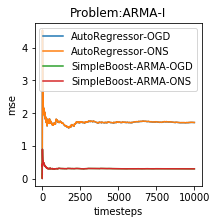

In [80]:
exp.graph()

### Setting II: Changing coefficients

We generate non-stationary time-series data assuming the $ARMA$ model, such that the coefficients are slowly changing with time. Specifically, we set $AR_{dyn}(t) = [−0.4,−0.5,0.4,0.4,0.1] \cdot \left(\frac{t}{10^4}\right) + [0.6,−0.4,0.4,−0.5,0.4] \cdot \left(1 - \frac{t}{10^4}\right)$, $MA_{dyn} = [0.32, −0.2]$ and noise terms $w_t ∼ Unif[-.5, .5]$.

In [81]:
ar_dyn = [np.array([-0.4,-0.5,0.4,0.4,0.1])* t / 10000 + 
          np.array([0.6,-0.4,0.4,-0.5,0.4]) * (1 - t / 10000)
          for t in range(T)]

ma_dyn = np.array([0.32, -0.2])
mean, noise_magnitude, noise_distribution = 0, 0.5, 'unif'

In [82]:
exp.add_problem('ARMA-v0', {'p' : ar_dyn, 'q' : ma_dyn, 'c' : mean,
                'noise_magnitude' : noise_magnitude, 'noise_distribution' : noise_distribution},
                name = 'II')

In [83]:
exp.scoreboard()

Average mse:
+----------------------+--------+---------+
|    Model\Problems    | ARMA-I | ARMA-II |
+----------------------+--------+---------+
|  AutoRegressor-OGD   | 1.716  |  1.198  |
|  AutoRegressor-ONS   | 1.719  |  1.198  |
| SimpleBoost-ARMA-OGD | 0.304  |  0.283  |
| SimpleBoost-ARMA-ONS | 0.304  |  0.283  |
+----------------------+--------+---------+


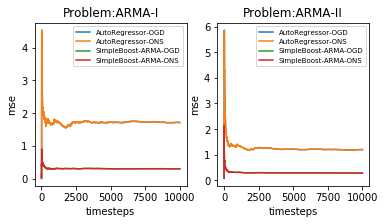

In [84]:
exp.graph()

### Setting III: Abrupt change

We again generate a non-stationary ARMA process, but here coefficients change abruptly. For the first half of time steps we use $\alpha = [0.6, -0.5, 0.4, -0.4, 0.3]$ and $\beta = [0.3, -0.2]$. For the second half, we set $\alpha = [-0.4, −0.5, 0.4, 0.4, 0.1]$ and $\beta = [−0.3, 0.2]$. The noise terms are uniformly distributed on $[-.5, .5]$.

In [85]:
ar_dyn = [np.array([0.6,-0.5,0.4,-0.4,0.3]) for _ in range(T // 2)] + \
         [np.array([-0.4,-0.5,0.4,0.4,0.1]) for _ in range(T // 2 + T % 2)]

ma_dyn = [np.array([0.3, -0.2]) for _ in range(T // 2)] + \
         [np.array([-0.3, 0.2]) for _ in range(T // 2 + T % 2)]

mean, noise_magnitude, noise_distribution = 0, 0.5, 'unif'

In [86]:
exp.add_problem('ARMA-v0', {'p' : ar_dyn, 'q' : ma_dyn, 'c' : mean,
                'noise_magnitude' : noise_magnitude, 'noise_distribution' : noise_distribution},
                name = 'III')

In [87]:
exp.scoreboard()

Average mse:
+----------------------+--------+---------+----------+
|    Model\Problems    | ARMA-I | ARMA-II | ARMA-III |
+----------------------+--------+---------+----------+
|  AutoRegressor-OGD   | 1.716  |  1.198  |  1.121   |
|  AutoRegressor-ONS   | 1.719  |  1.198  |  1.121   |
| SimpleBoost-ARMA-OGD | 0.304  |  0.283  |  0.248   |
| SimpleBoost-ARMA-ONS | 0.304  |  0.283  |  0.248   |
+----------------------+--------+---------+----------+


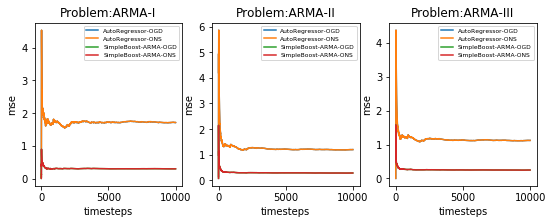

In [88]:
exp.graph()

### Setting IV: Correlated noise

We consider an ARMA process generated by $\alpha = [0.11, -0.5]$ and $\beta = [0.41, -0.39, -0.685, 0.1]$. The noise terms are now correlated; each noise term is normally distributed, with expectation that
is the value of the previous noise term, such that $w_t ∼ N(w_{t−1},0.32)$, and then clip $w_t$ to be in the range $[−1, 1]$.

In [89]:
ar_dyn = np.array([0.11, -0.5])
ma_dyn = np.array([0.41, -0.39, -0.685, 0.1])
mean = 0
noise_magnitude = 0.3

In [90]:
def generate_noise(T, noise_magnitude):
    noise_list = [noise_magnitude * random.normal(generate_key())]
    for t in range(T - 1):
        next_noise = noise_list[t] + noise_magnitude * random.normal(generate_key())
        next_noise = min(1, next_noise)
        next_noise = max(-1, next_noise)
        noise_list.append(next_noise)
    return noise_list

In [91]:
noise_list = generate_noise(T + ma_dyn.shape[0] + 1, noise_magnitude)

In [92]:
exp.add_problem('ARMA-v0', {'p' : ar_dyn, 'q' : ma_dyn, 'noise_list' : noise_list, 'c' : mean},
                name = 'IV')

In [93]:
exp.scoreboard()

Average mse:
+----------------------+--------+---------+----------+---------+
|    Model\Problems    | ARMA-I | ARMA-II | ARMA-III | ARMA-IV |
+----------------------+--------+---------+----------+---------+
|  AutoRegressor-OGD   | 1.716  |  1.198  |  1.121   | 168.793 |
|  AutoRegressor-ONS   | 1.719  |  1.198  |  1.121   | 168.491 |
| SimpleBoost-ARMA-OGD | 0.304  |  0.283  |  0.248   | 183.766 |
| SimpleBoost-ARMA-ONS | 0.304  |  0.283  |  0.248   | 184.001 |
+----------------------+--------+---------+----------+---------+


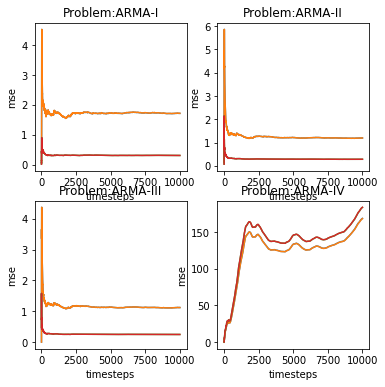

In [94]:
exp.graph()

## Real World Data

### I. Predicting CO contaminate concentration

We provide results on real-world time-series data, from the UCI Machine Learning Repository. The data contains 2764 instances of hourly averaged measurements of air quality properties from an Italian city throughout one year, as measured by chemical sensors. Specifically, our goal was to predict the level of CO contaminate concentration.

In [6]:
T = 2700
exp = Experiment()

exp.initialize(timesteps = T)

exp.add_problem('UCI-Indoor-v0')

exp.add_model('AutoRegressor', {'p' : p, 'optimizer': ogd}, name = 'OGD')
exp.add_model('AutoRegressor', {'p' : p, 'optimizer': ons}, name = 'ONS')

exp.add_model('SimpleBoost', {'model_id' : 'AutoRegressor', 'model_params' : {'p' : p, 'optimizer': ogd},
                'N': N, 'reg' : 0.0}, name = 'ARMA-OGD')
exp.add_model('SimpleBoost', {'model_id' : 'AutoRegressor', 'model_params' : {'p' : p, 'optimizer': ons},
                'N': N, 'reg' : 0.0}, name = 'ARMA-ONS')

In [7]:
exp.scoreboard()

Average mse:
+----------------------+------------+
|    Model\Problems    | UCI-..or-  |
+----------------------+------------+
|  AutoRegressor-OGD   | 101330.703 |
|  AutoRegressor-ONS   | 101320.781 |
| SimpleBoost-ARMA-OGD | 255756.281 |
| SimpleBoost-ARMA-ONS | 255828.734 |
+----------------------+------------+


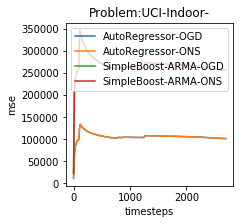

In [8]:
exp.graph()

### II. Predicting El Nino

In [17]:
T = 5900
exp = Experiment()

exp.initialize(timesteps = T)

exp.add_problem('ENSO-v0', {'input_signals' : ['oni'], 'timeline' : 1})
exp.add_problem('ENSO-v0', {'input_signals' : ['oni'], 'timeline' : 3})
exp.add_problem('ENSO-v0', {'input_signals' : ['oni'], 'timeline' : 6})
exp.add_problem('ENSO-v0', {'input_signals' : ['oni'], 'timeline' : 12})

exp.add_model('AutoRegressor', {'p' : p, 'optimizer': ogd}, name = 'OGD')
exp.add_model('AutoRegressor', {'p' : p, 'optimizer': ons}, name = 'ONS')

exp.add_model('SimpleBoost', {'model_id' : 'AutoRegressor', 'model_params' : {'p' : p, 'optimizer': ogd},
                'N': N, 'reg' : 0.0}, name = 'ARMA-OGD')
exp.add_model('SimpleBoost', {'model_id' : 'AutoRegressor', 'model_params' : {'p' : p, 'optimizer': ons},
                'N': N, 'reg' : 0.0}, name = 'ARMA-ONS')

In [ ]:
exp.scoreboard()

In [ ]:
exp.graph()